# Preparing Data

In [1]:
import numpy as np
import scanpy as sc

adata = sc.read_h5ad("/oak/stanford/projects/kibr/Reorganizing/Projects/James/lipid-droplet-single-cell-pipeline/data/processed/spatial_niche_iterations/5APR2025.h5ad")
folder_to_group_mapping = adata.obs[["folder", "group"]].drop_duplicates().set_index("folder")["group"].to_dict()

adata.obs["log_lipid_droplet_area"] = np.log1p(adata.obs["lipid_droplet_area"])
adata.obs["log_plin2_area"] = np.log1p(adata.obs["plin2_area"])
adata.obs["log_oil_red_o_area"] = np.log1p(adata.obs["oil_red_o_area"])
adata.obs["lipid_droplet"] = adata.obs["log_lipid_droplet_area"].gt(0).astype(int)
adata.obs["near_amyloid"] = adata.obs["distance_to_nearest_amyloid"].lt(60).astype(int)

/oak/stanford/projects/kibr/Reorganizing/Packages/using_parameters_instead/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Loading Modules

In [2]:
import sys
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("/oak/stanford/projects/kibr/Reorganizing/Packages/using_parameters_instead")
from src.using_parameters_instead import formula, model, summary, statistics, plotting

importlib.reload(formula)
importlib.reload(model)
importlib.reload(summary)
importlib.reload(statistics)
importlib.reload(plotting)

/oak/stanford/projects/kibr/Reorganizing/Packages/using_parameters_instead/src/using_parameters_instead/summary.py:50: SyntaxWarning: invalid escape sequence '\['
  df = df.query("index.str.contains('\[') & ~index.str.contains(':')")


<module 'src.using_parameters_instead.plotting' from '/oak/stanford/projects/kibr/Reorganizing/Packages/using_parameters_instead/src/using_parameters_instead/plotting.py'>

# Primary Training Routing

In [109]:
subset = adata[adata.obs["cell_type"].eq("Astrocyte")]

subset.obs["transcript_counts_red"] = np.log(subset.layers["transcript"].sum(axis=1) / subset.layers["transcript"].sum(axis=1).mean())

design_matrix_factory = formula.DesignMatrixFactory(
    "folder", 
    ["lipid_droplet", "near_amyloid", "spatial_niche"],
    intercept = False
)

differential_expression_testing = model.DifferentialExpressionTesting(
    model.NegativeBinomialModelFitter(),
    design_matrix_factory
)

results = differential_expression_testing.fit_model_over_features(
    adata=subset, 
    layer="transcript",
    min_expression=0.05,
    reset=False,
    offset=subset.obs["transcript_counts_red"]
)

100%|██████████| 366/366 [11:18<00:00,  1.85s/it]


In [6]:
import pickle
pickle.dump(results, open("../data/example_output/Microglia-PVM.pickle", "wb"))

# Statistical Testing

## Group (Total)

<unknown>:1: SyntaxWarning: invalid escape sequence '\['


Text(0.5, 1.0, 'Microglia-PVM\nND 33 vs AD 33')

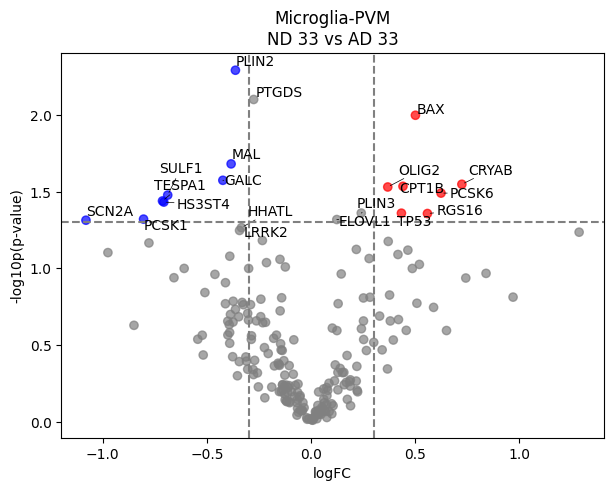

In [97]:
summarizer = summary.ModelResultSummarizer(design_matrix_factory)
df = summarizer.summary_dataframe(results)
df["group"] = df["specimen"].replace(folder_to_group_mapping)
table = pd.DataFrame({
    feature: statistics.CoefficientStatistics(df).generate_stats_entry_dict("ND 33", "AD 33", feature, equal_var=False)
    for feature in adata.var_names.intersection(df.columns)
}).T
plotting.volcano_plot(table, .3, top_n_genes=20)
plt.title("Microglia-PVM\nND 33 vs AD 33")

<unknown>:1: SyntaxWarning: invalid escape sequence '\['


Text(0.5, 1.0, 'Astrocyte\nND 33 vs AD 44')

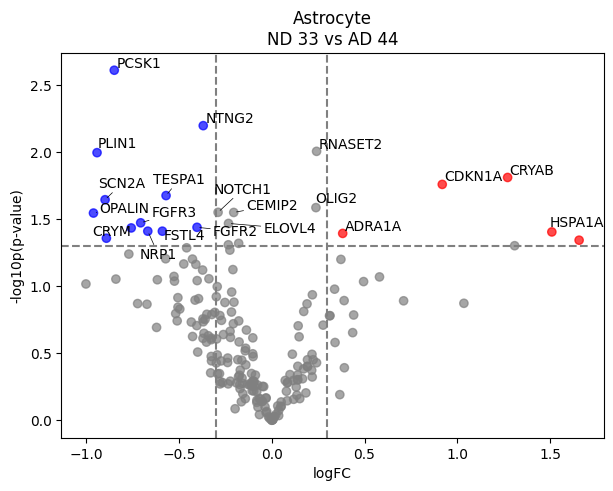

In [98]:
summarizer = summary.ModelResultSummarizer(design_matrix_factory)
df = summarizer.summary_dataframe(results)
df["group"] = df["specimen"].replace(folder_to_group_mapping)
table = pd.DataFrame({
    feature: statistics.CoefficientStatistics(df).generate_stats_entry_dict("ND 33", "AD 44", feature, equal_var=False)
    for feature in adata.var_names.intersection(df.columns)
}).T
plotting.volcano_plot(table, .3, top_n_genes=20)
plt.title("Astrocyte\nND 33 vs AD 44")

<Axes: xlabel='group', ylabel='PCSK1'>

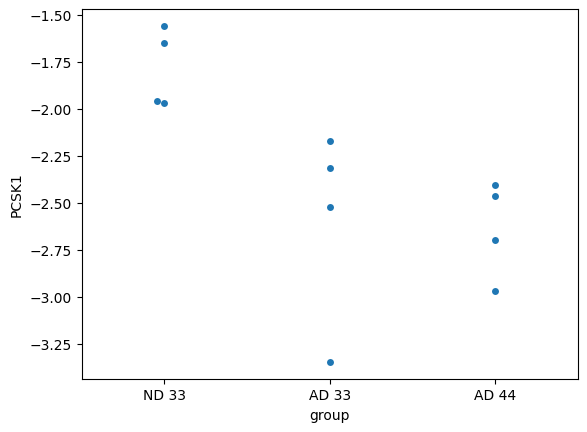

In [102]:
import seaborn as sns
sns.swarmplot(
    df,
    x="group",
    y="PCSK1",
    order=["ND 33", "AD 33", "AD 44"]
)

# Group (lipid droplet)

/oak/stanford/projects/kibr/Reorganizing/Packages/using_parameters_instead/src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \


Text(0.5, 1.0, 'Astrocyte\nND 33 vs AD 33')

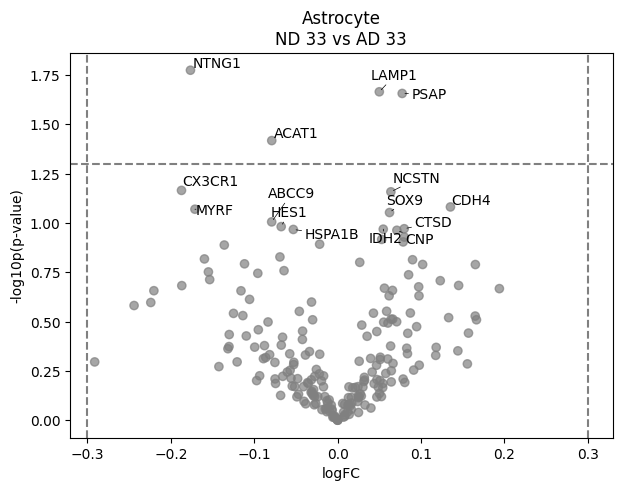

In [103]:
summarizer = summary.ModelResultSummarizer(design_matrix_factory)
df = summarizer.summary_dataframe(results, covariate="lipid_droplet")
df["group"] = df["specimen"].replace(folder_to_group_mapping)
table = pd.DataFrame({
    feature: statistics.CoefficientStatistics(df).generate_stats_entry_dict("ND 33", "AD 33", feature, equal_var=False)
    for feature in adata.var_names.intersection(df.columns)
}).T
ad_33 = table["logFC"]
plotting.volcano_plot(table.query("abs(logFC) < 2"), .3)
plt.title("Astrocyte\nND 33 vs AD 33")


/oak/stanford/projects/kibr/Reorganizing/Packages/using_parameters_instead/src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \


Text(0.5, 1.0, 'Astrocyte\nND 33 vs AD 44')

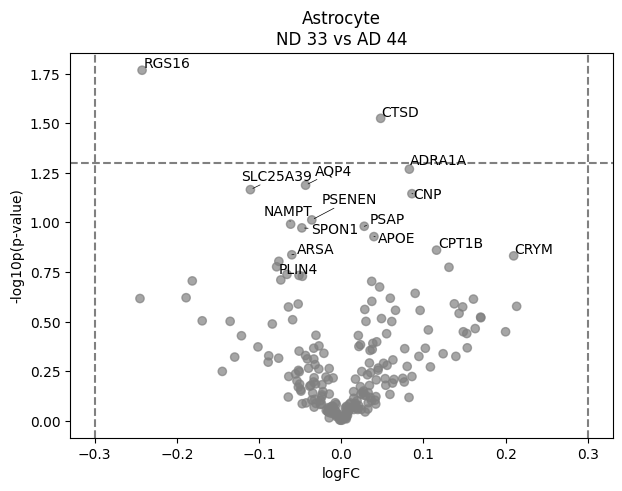

In [104]:
summarizer = summary.ModelResultSummarizer(design_matrix_factory)
df = summarizer.summary_dataframe(results, covariate="lipid_droplet")
df["group"] = df["specimen"].replace(folder_to_group_mapping)
table = pd.DataFrame({
    feature: statistics.CoefficientStatistics(df).generate_stats_entry_dict("ND 33", "AD 44", feature, equal_var=False)
    for feature in adata.var_names.intersection(df.columns)
}).T
ad_44 = table["logFC"]
plotting.volcano_plot(table.query("abs(logFC) < 2"), .3)
plt.title("Astrocyte\nND 33 vs AD 44")

# Group (near amyloid)

/oak/stanford/projects/kibr/Reorganizing/Packages/using_parameters_instead/src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \


Text(0.5, 1.0, 'Astrocyte\nND 33 vs AD 44')

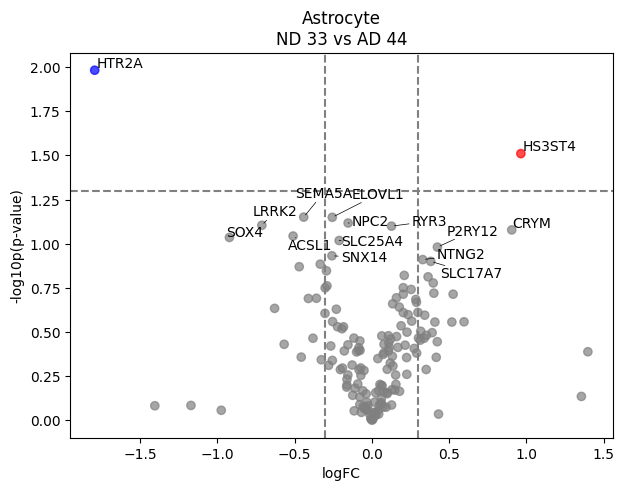

In [105]:
summarizer = summary.ModelResultSummarizer(design_matrix_factory)
df = summarizer.summary_dataframe(results, covariate="near_amyloid")
df["group"] = df["specimen"].replace(folder_to_group_mapping)
table = pd.DataFrame({
    feature: statistics.CoefficientStatistics(df).generate_stats_entry_dict("ND 33", "AD 33", feature, equal_var=False)
    for feature in adata.var_names.intersection(df.columns)
}).T.query("abs(logFC) < 2")
ad_44 = table["logFC"]
plotting.volcano_plot(table, .3)
plt.title("Astrocyte\nND 33 vs AD 44")

/oak/stanford/projects/kibr/Reorganizing/Packages/using_parameters_instead/src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \


Text(0.5, 1.0, 'Astrocyte\nND 33 vs AD 44')

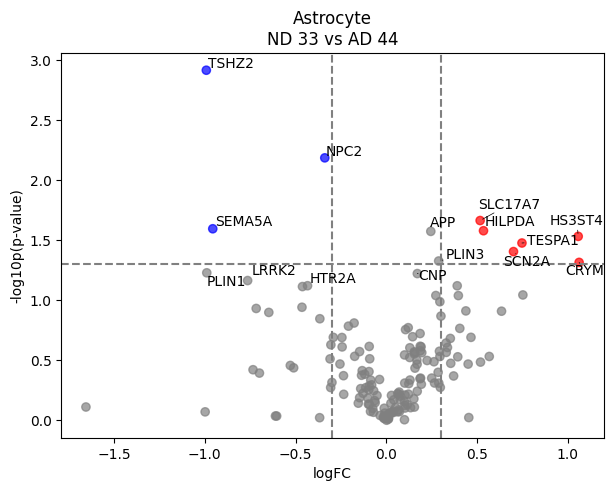

In [106]:
summarizer = summary.ModelResultSummarizer(design_matrix_factory)
df = summarizer.summary_dataframe(results, covariate="near_amyloid")
df["group"] = df["specimen"].replace(folder_to_group_mapping)
table = pd.DataFrame({
    feature: statistics.CoefficientStatistics(df).generate_stats_entry_dict("ND 33", "AD 44", feature, equal_var=False)
    for feature in adata.var_names.intersection(df.columns)
}).T.query("abs(logFC) < 2")
ad_44 = table["logFC"]
plotting.volcano_plot(table, .3)
plt.title("Astrocyte\nND 33 vs AD 44")

<Axes: xlabel='group', ylabel='HILPDA'>

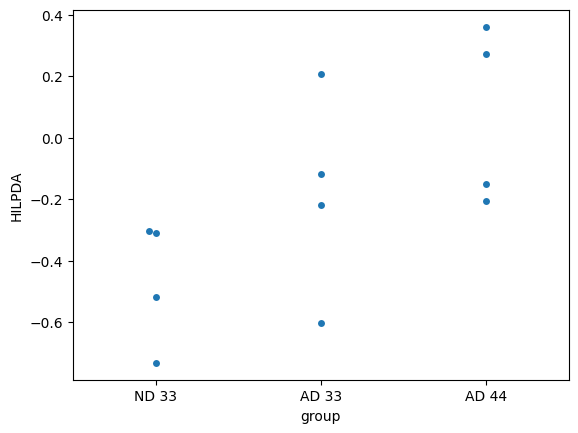

In [110]:
sns.swarmplot(df, x="group", y="HILPDA", order=["ND 33", "AD 33", "AD 44"])